In [1]:
import anndata
import csv
import numpy as np
import pandas as pd
import scanpy as sc 
import scipy
import pickle
import anndata as ad
from scipy.sparse import csr_matrix 
import scSDNE as SD
import matplotlib.pyplot as plt

# Data Preparation
Filter cells and genes and select highly variable genes.

        cell_type
0     Inflam. FIB
1       FBN1+ FIB
2     Inflam. FIB
3     Inflam. FIB
4     Inflam. FIB
...           ...
5006   Inflam. TC
5007           TC
5008   Inflam. TC
5009          NKT
5010   Inflam. TC

[5011 rows x 1 columns]


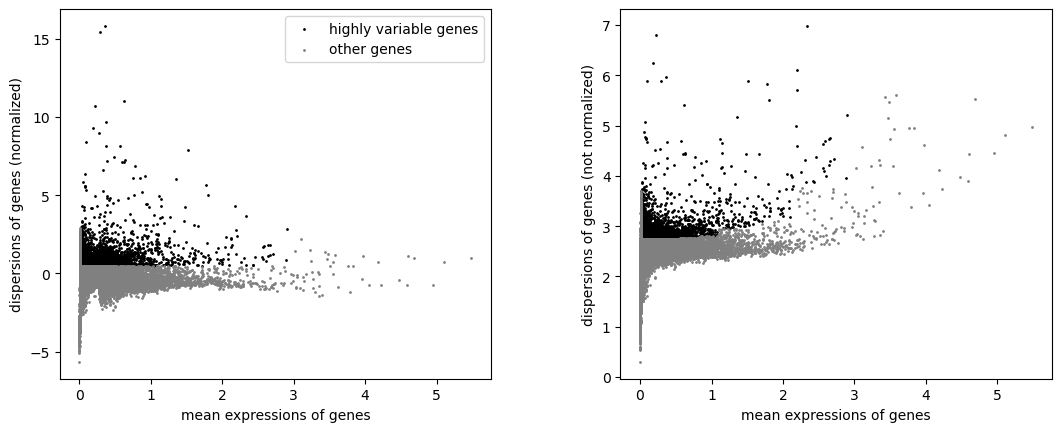

View of AnnData object with n_obs × n_vars = 4725 × 3769
    obs: 'cell_type', 'n_genes', 'percent_mito'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [2]:
# example 
dX=sc.read_mtx("D:\data\AD\matrix.mtx",dtype="float32")
adata = ad.AnnData(dX)
adata=ad.AnnData(adata.X.A)
cell=pd.read_csv("D:\data\AD\cell.tsv", sep='\t',header=0)
adata.obs['cell_type'] = cell.values  
print(adata.obs)
gene=pd.read_csv("D:\data\AD\gene.tsv",sep='\t',header=0)
adata.var_names = gene["0"] 

#Filter cells and genes
sc.pp.filter_cells(adata,min_genes=200)
sc.pp.filter_genes(adata,min_cells=3)

#Identify mitochondrial genes and filter cells
mito_genes=adata.var_names.str.startswith('MT-')
adata.obs['percent_mito']=np.sum(adata[:,mito_genes].X,axis=1)/np.sum(adata.X,axis=1)
adata = adata[adata.obs['percent_mito']<0.05,:]

adata=adata[adata.obs.n_genes<2500,:]

#Identify highly variable genes in all cell types
sc.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=3,min_disp=0.5)
#Visualization
sc.pl.highly_variable_genes(adata)

#Leave high-variability genes for further analysis.
adata=adata[:,adata.var.highly_variable]
adata

# Select cell types for cell communication analysis

In [3]:
fib=adata[adata.obs.cell_type=="Inflam. FIB"]
DC=adata[adata.obs.cell_type=="Inflam. DC"]
mat=pd.DataFrame(data=fib.X,index=fib.obs_names,columns=fib.var_names)
mat.to_csv("C:/Users/123/Desktop/DeepSEM/input/FIB.csv")
mat1=pd.DataFrame(data=DC.X,index=DC.obs_names,columns=DC.var_names)
mat1.to_csv("C:/Users/123/Desktop/DeepSEM/input/DC.csv")

# Run DeepSEM for GRN inference task
Please rename the document to the name of the cell type.

In [ ]:
!python main.py --task celltype_GRN --data_file input/FIB.csv --net_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 50  --save_name out
!python main.py --task celltype_GRN --data_file input/DC.csv --net_file demo_data/GRN_inference/input/500_ChIP-seq_hESC/label.csv --setting new --alpha 0.1 --beta 0.01 --n_epochs 50  --save_name out

# Run scSDNE for significant interactions

In [4]:
#Inflam.FIB和Inflam.DC合并后的anndata
adata = ad.concat([fib, DC], axis=0)
adata

AnnData object with n_obs × n_vars = 547 × 3769
    obs: 'cell_type', 'n_genes', 'percent_mito'

In [5]:
SD = SD.scSDNE(data = adata, 
                       source_celltype = 'Inflam. FIB', 
                       target_celltype = 'Inflam. DC', 
                       obs_label ='cell_type', 
                       rebuild_GRN = False, # timer 
                       GRN_file_dir = "C:/Users/123/Desktop/DeepSEM/out", 
                       verbose = False)

In [6]:
#get embeddings and significant L-R pairs
emb = SD.get_embeds(train = True)
SD_pairs = SD.null_test()


Total enriched: 6 / 14205361


In [7]:
SD_pairs

,ligand,receptor,dist,correspondence,p_val,enriched_rank
CCL19_CCR7,CCL19,CCR7,2.816226e-10,0.952239,0.001615,1
CXCL12_CXCR4,CXCL12,CXCR4,4.114919e-10,0.941710,0.002001,2
THBS2_CD36,THBS2,CD36,3.575835e-09,0.825331,0.007039,3
CD248_IL6R,CD248,IL6R,1.190023e-08,0.843309,0.013336,4
BMP4_ACVR2A,BMP4,ACVR2A,1.552187e-07,0.635128,0.043546,5
CNTN1_NOTCH2,CNTN1,NOTCH2,1.553570e-07,0.639879,0.043583,6


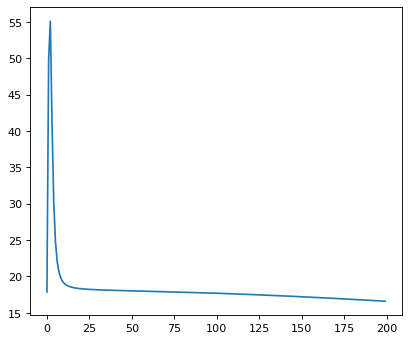

In [8]:
SD.plot_losses()